## Project: Value at Risk

Create a streamlit app that shows the value of a variable at risk.

User inputs:
- Initial investment
- Stocks and weights
- Holding period
- Confidence interval

Yields:
- Value at risk: Parametric, Historical, Monte Carlo
- Conditional Value at Risk
- Denoised Value at Risk

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
sns.set()

In [3]:
def get_data(stocks, start, end):
    data = yf.download(stocks, start=start_date, end=end_date)
    return data

In [38]:
def calc_var_param(initial_investment, data, weights, confidence_interval):
    returns = np.log(data['Adj Close']/data['Adj Close'].shift(1)).dropna()
    cov_matrix = returns.cov() # covariance matrix
    avg_returns = returns.mean() # average return per stock
    print(f'Average return per stock:', avg_returns.values)
    
    port_mean = avg_returns.dot(weights) # mean of portfolio
    port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
    print('Portfolio mean:', port_mean, 'Portfolio stdev:', port_stdev)
    
    mean_investment = initial_investment * (1 + port_mean)
    stdev_investment = initial_investment * port_stdev
    print('Mean investment:', mean_investment, 'Stdev investment:', stdev_investment)
    
    confidence_level = 1 - confidence_interval
    cutoff = norm.ppf(confidence_level, mean_investment, stdev_investment)
    
    # Estimate VaR
    var_1d = initial_investment - cutoff
    print('Parametric VaR:', var_1d)
    return var_1d

In [4]:
data = get_data(stocks, start_date, end_date)

[*********************100%***********************]  4 of 4 completed


In [43]:
def calc_var_parametric(initial_investment, data, weights, conf_level):
    # Asset returns
    stock_returns = np.log(data['Adj Close'] / data['Adj Close'].shift(1)).dropna()
    mean_stock_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov()
    
    # Portfolio returns
    port_std = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
    port_mean = mean_stock_returns.dot(weights)
    
    # VaR Asset level
    alpha = norm.ppf(1 - conf_level, stock_returns.mean(), port_std)
    VaR_asset = (initial_investment - initial_investment * (1 + alpha))
  
    # VaR Portfolio level 
    VaR_port = port_mean - norm.ppf(conf_level) * port_std
    VaR_amount = initial_investment * (1 - np.exp(VaR_port))
    
    # Alt
    mean_investment = initial_investment * (1 + port_mean) 
    stdev_investment = initial_investment * port_std
    port_cutoff = norm.ppf(1 - conf_level, mean_investment, stdev_investment)
    VaR_port_1d = initial_investment - port_cutoff
    
    return VaR_amount, VaR_asset

In [44]:
# Inputs
total_investment = 1000
stocks = ['AAPL','MSFT', 'C', 'DIS']
weights = np.array([.25, .3, .15, .3])
confidence_level = 0.95
num_days = 15

start_date = pd.to_datetime('today') - pd.DateOffset(years=5)
end_date = pd.to_datetime('today')

In [45]:
calc_var_parametric(total_investment, data, weights, confidence_level)

(28.250767975791625,
 array([28.05783067, 29.37102131, 29.14789699, 28.19850314]))

In [46]:
calc_var_param(total_investment, data, weights, confidence_level)

Average return per stock: [ 1.11437836e-03 -1.98812281e-04  2.43120389e-05  9.73705895e-04]
Portfolio mean: 0.000514709480459676 Portfolio stdev: 0.017735443783202416
Mean investment: 1000.5147094804596 Stdev investment: 17.735443783202417
Parametric VaR: 28.657499551934848


28.657499551934848

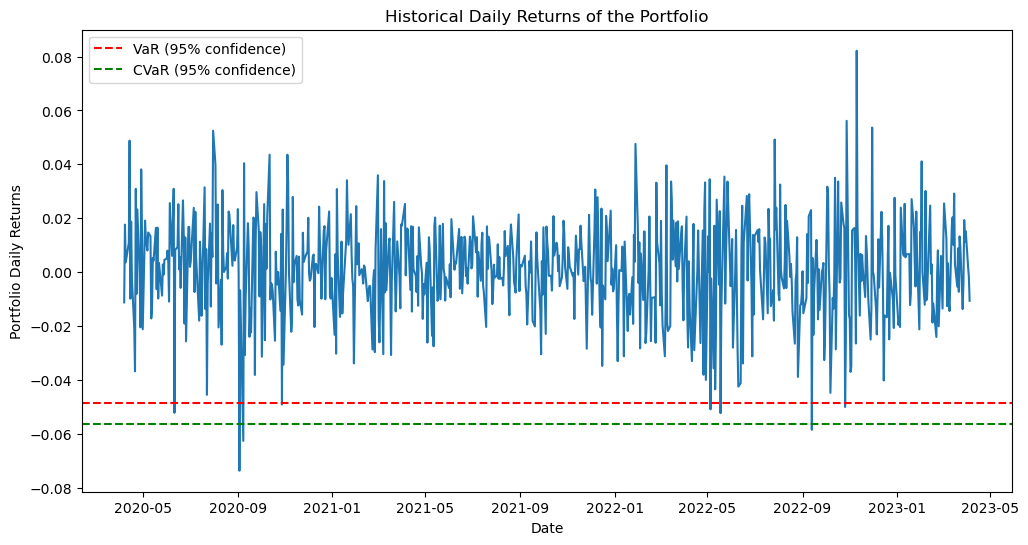

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns)
plt.axhline(y=VaR_hist, color='r', linestyle='--', label='VaR (95% confidence)')
plt.axhline(y=CVaR_hist, color='g', linestyle='--', label='CVaR (95% confidence)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Portfolio Daily Returns')
plt.title('Historical Daily Returns of the Portfolio')
plt.show()
